In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc








In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Building the Xception model**

In [5]:
model = Sequential()
base_model = Xception(weights='imagenet',
                      include_top=False,
                      input_shape=(128, 128, 3))

base_model.trainable = False
model.add(base_model)

model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 4, 4, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,960,681 (87.59 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [6]:
optimizer = Adam(learning_rate=0.001)
loss_function = BinaryCrossentropy(from_logits=False)
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

# **Data Augmentation**

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Pneumonia dataset-Copy/split_chest_xray/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/My Drive/Pneumonia dataset-Copy/split_chest_xray/val',
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/Pneumonia dataset-Copy/split_chest_xray/test',
    target_size=(128, 128),
    batch_size=20,
    class_mode='binary',
    shuffle=False
)


Found 4088 images belonging to 2 classes.
Found 511 images belonging to 2 classes.
Found 512 images belonging to 2 classes.


# **Training the model**

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, learning_rate_reduction]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 2823s 21s/step - accuracy: 0.8379 - loss: 0.5910 - val_accuracy: 0.8493 - val_loss: 0.3252 - learning_rate: 0.0010
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 97s 561ms/step - accuracy: 0.9080 - loss: 0.2211 - val_accuracy: 0.8552 - val_loss: 0.3046 - learning_rate: 0.0010
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 72s 539ms/step - accuracy: 0.9235 - loss: 0.1945 - val_accuracy: 0.9139 - val_loss: 0.2263 - learning_rate: 0.0010
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 84s 547ms/step - accuracy: 0.9215 - loss: 0.1971 - val_accuracy: 0.9256 - val_loss: 0.2077 - learning_rate: 0.0010
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 81s 549ms/step - accuracy: 0.9264 - loss: 0.1850 - val_accuracy: 0.9198 - val_loss: 0.2184 - learning_rate: 0.0010
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.9292 - loss: 0.1844
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
128/128 ━━━━━━━━━━━━━━━━━━━━ 86s 577ms/step - accuracy: 0.9292 - loss: 0

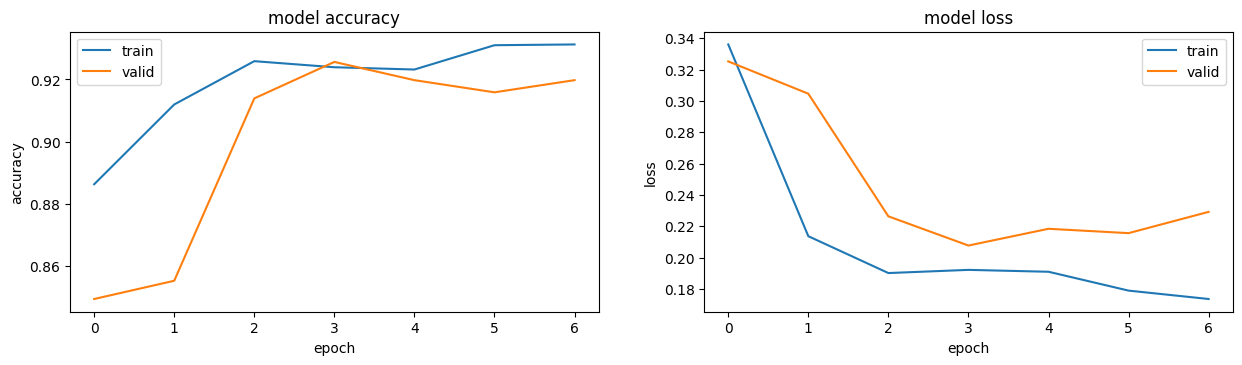

In [9]:
plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

# **Evaluating and Predicting**

In [10]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 347s 14s/step - accuracy: 0.8651 - loss: 0.2727
Test Loss: 0.1965957134962082, Test Accuracy: 0.912109375


In [11]:
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_generator.classes


26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step


# **Confusion Matrix**

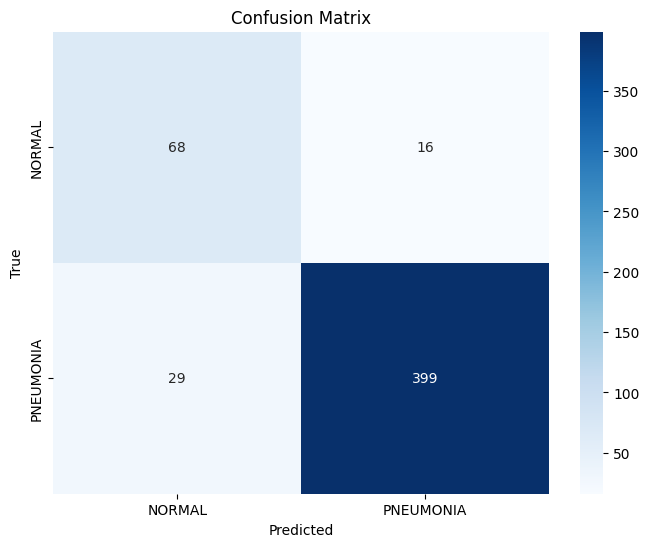

In [12]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# **Classification report**

In [13]:
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)


              precision    recall  f1-score   support

      NORMAL       0.70      0.81      0.75        84
   PNEUMONIA       0.96      0.93      0.95       428

    accuracy                           0.91       512
   macro avg       0.83      0.87      0.85       512
weighted avg       0.92      0.91      0.91       512



# **AUC and ROC**

In [14]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc}")



AUC: 0.9661493101913662


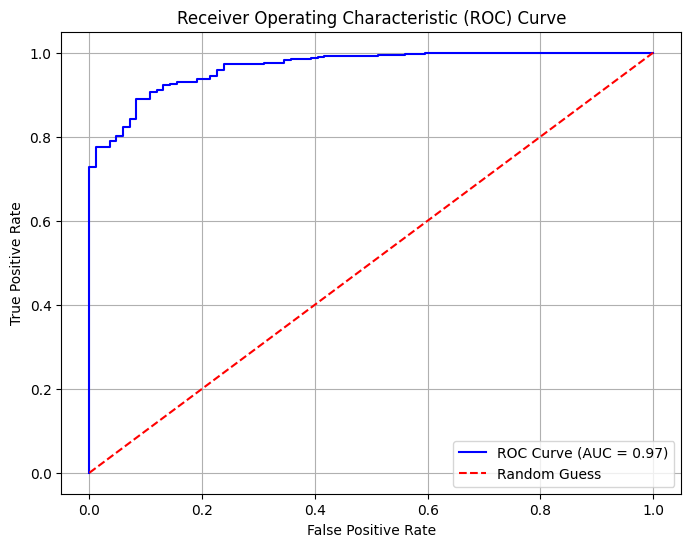

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
